**Relevant reading for this problem set**:
<a href="https://moderndive.com/8-confidence-intervals.html"
target="_blank">ModernDive Chapter 8: Bootstrapping and Confidence
Intervals</a>.

## Background

In this problem set we will use a small **sample** of data from the
[General Social Survey](http://gss.norc.org/). The survey is designed to
monitor changes in both social characteristics and attitudes. You will
work with a **sample** from one neighborhood. The full neighborhood of
**ALL individuals** is the population. For this problem set we do
**not** know the **true population parameters** for any of the
variables, because we do not have data on every person in the
neighborhood.

## Setup

First load the necessary packages

In [11]:
# Recall that loading the tidyverse "umbrella" package loads ggplot2, dplyr, and
# readr all at once. Feel free to load these packages any way you choose.
library('tidyverse')
library('moderndive')

Next load the data set, from where it is stored on the web:

In [12]:
gss_sample = read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSypSoDCMH2N76Vo2dZRPkw2q3t1mbvAXlOtgPDIsHg4NclAQFmER-BdvXH9_lrT40UQCVdPXOi_NMJ/pub?gid=257689625&single=true&output=csv", col_types = cols())

gss_sample |> glimpse()

Rows: 100
Columns: 3
$ age     <dbl> 79, 23, 31, 53, 39, 59, 45, 84, 52, 60, 21, 25, 56, 68, 58, 42…
$ race    <chr> "White", "White", "POC", "White", "White", "White", "White", "…
$ tvhours <dbl> 1, 1, 4, 4, 1, 1, 2, 3, 4, 3, 0, 3, 1, 3, 4, 1, 1, 2, 1, 5, 2,…


Be sure to take a look at the data in the **viewer**. Each row in the
data set is a person that was surveyed (100 rows or cases in total). The
variables in the data set include each respondent’s `age`, `race`, and
number of hours of TV watched a day `tvhours`.

**Setting a seed:** We will take some random samples and build sampling
distributions in this lab. In order to make sure R takes the same random
sample every time you run your code, you can do what is called “setting
a seed”. Do this in any code chunk that you take a random sample!

You can set a seed like so. Any number will do. (You do not need to run
this right now…just showing you how)

In [13]:
set.seed(45)

# Confidence intervals from a bootstrap resample

### Step 1: Take 1000 bootstrap resamples

The following code tells R to take 1000 bootstrap resamples from the
`gss_sample` data. You can set the seed to whatever value you like!

In [14]:
set.seed(10)

boot_samp_1000 = gss_sample |> 
  rep_sample_n(size = 100, reps = 1000, replace = TRUE)

boot_samp_1000 |> head()

replicate,age,race,tvhours
<int>,<dbl>,<chr>,<dbl>
1,52,POC,4
1,25,White,0
1,57,White,1
1,32,POC,1
1,65,White,4
1,80,White,8


Note a few important details about the `rep_sample_n` function, and
bootstrap sampling in general:

-   `size = 100` tells R that each bootstrap resample we take has 100
    cases… the size of the original sample
-   `reps = 1000` tells R to take 1000 bootstrap resamples (each of size
    100).
-   The `replace = TRUE` argument tells R that in each bootstrap
    resample, we can include a row from `gss_sample` multiple times. So
    if for instance, respondent \# 12 is the first random resample taken
    here, respondent 12 is still available to be resampled **again** at
    random. Thus, some people may appear **multiple times** in our
    bootstrap resample, and some people from the original data set may
    not appear at all.
-   We save the results in a data frame `boot_samp_1000`.

Take a look at the `boot_samp_1000` data frame we just generated in
RStudio’s data viewer. Note that the `replicate` column labels each
bootstrap resample (the first 100 rows are labeled 1, the next 100 rows
are labeled 2, etc.)

## Question 1

How many rows does `boot_samp_1000` have? **Why?**

**Answer:** 100,000 rows. Reps x sample size

In [15]:
#Viewing number of rows in our dataframe
boot_samp_1000 |> nrow()


[1] 100000

### Step 2: Calculate the bootstrap statistic

Let’s say we want to use the bootstrap resample that we just generated
to calculate a confidence interval for the population mean $\mu_{tv}$ of
`tvhours`. To do so, we need to know the sample mean $\bar{x}$ of
`tvhours` **for each of the 1000 bootstrap resamples**. In this case,
the sample mean $\bar{x}$ of `tvhours` for **each bootstrap resample**
is our **BOOTSTRAP STATISTIC**. We can calculate that with two lines of
code, like so:

In [16]:
boot_distrib_tv = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat = mean(tvhours))

boot_distrib_tv |> head()

replicate,boot_stat
<int>,<dbl>
1,3.67
2,3.53
3,4.16
4,2.70
5,2.35
6,3.38


Note that:

-   The `group_by()` argument tells R to take the sample mean of
    `tvhours` **separately** for each different `replicate` in the
    bootstrap resample.
-   We put the sample mean for each bootstrap resample in a column
    called `boot_stat`

> This is the bootstrap distribution for the mean of `tvhours`!

Take a look at the `boot_distrib_tv` we just created in RStudio’s data
viewer.

## Question 2

How many values of the bootstrap statistic `boot_stat` are there? Please
explain **why** there are this many values of the bootstrap statistic.

**Answer:**. 1,000 values of boot_stat. This value corresponds to the number of samples.

### Visualizing the bootstrap distribution

Make a histogram of the `boot_stat` values from `boot_distrib_tv`.

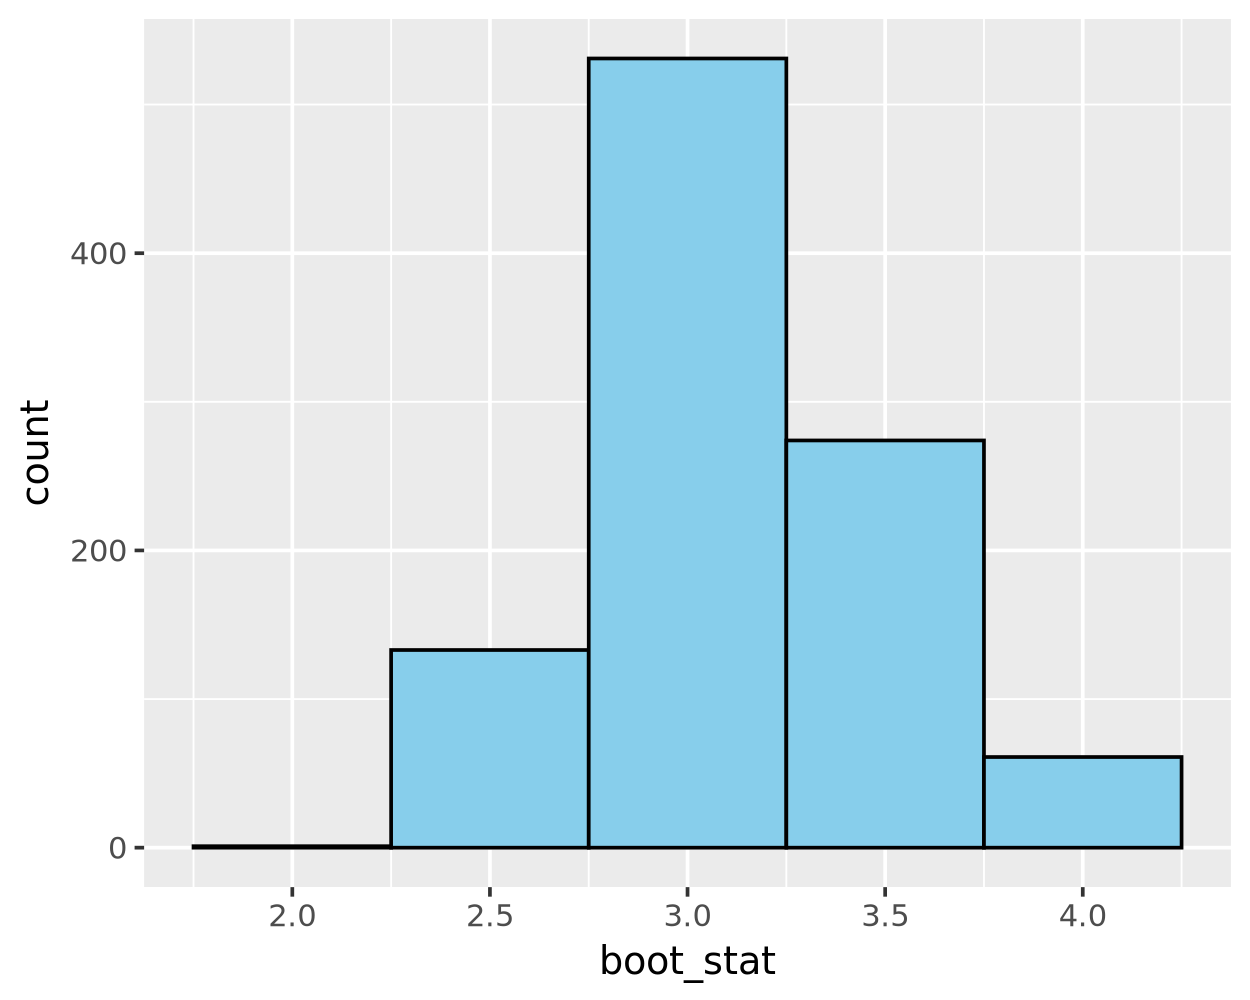

In [21]:
ggplot(boot_distrib_tv, aes(x = boot_stat )) +
geom_histogram(binwidth = 0.5, color = "black", fill = "skyblue")



### Step 3: CI from a bootstrap resample

### a) CI using the 95% rule

We can now use the bootstrap distribution for the sample mean `tvhours`
$\bar{x}$ to calculate a 95% confidence interval for the population mean
`tvhours` $\mu_{tv}$, using the “95% rule for bell shaped
distributions”, which states that the middle 95% of values of a
bell/normal shaped distribution are between

$$\text{mean} \pm 1.96 \cdot SD$$

-   the mean here would be the mean of the bootstrap distribution
-   the SD here is the standard deviation of the bootstrap distribution,
    which recall has a special name: the **standard error**.

We can thus apply the 95% rule, like so:

In [18]:
boot_distrib_tv |>
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
3.12847,0.3586246,2.425566,3.831374


### b) CI using percentile method

You can also calculate a 95% confidence interval using the percentile
method. The logic goes like this:

Since our bootstrap resample had 1000 values of `boot_stat`:

1.  950 of the `boot_stat` values fall **inside** this 95% confidence
    interval, i.e. 95%
2.  25 values fall **below** it. i.e. the lower 2.5%
3.  25 values fall **above** it. i.e. the higher 2.5%

totaling 100%. We can use **the quantiles** of the bootstrap
distribution to find these values like so:

In [19]:
prct_ci_tv = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

prct_ci_tv

lower_ci,upper_ci
<dbl>,<dbl>
2.48,3.91025


This method

-   Asks R to identify the 0.025 quantile of the bootstrap sample means…
    this is the value **below** which **2.5% of the values of
    `boot_stat`** fall (or 25 cases in this example… 25/1000 = 0.025)
-   Asks R to identify the 0.975 quantile for the bootstrap sample
    means… this is the value **above** which the other **2.5% of the
    values of `boot_stat`** fall (or 25 cases in this example 975/1000 =
    0.975)
-   The middle 95% of the values fall between these two quantiles

Based on these results, we are 95% confident that the **true mean hours
of TV watched $\mu_{tv}$ in the population** is between the upper and
lower CI we just calculated.

### Visualizing the Confidence interval

Display the bootstrap distribution and the 95% confidence intervals we just
calculated below. 

1. Make a histogram of the `boot_stat` values from `boot_distrib_tv`.
2. Add a green line for the lower bound of the 95% CI, and,
3. a blue line fir the upper bound.
 
950 of the 1000 bootstrap resamples had a mean for `tvhours` that fell **between**
the green and blue lines…25 of the samples had a mean above the blue
line, and 25 of the samples had a mean below the green line.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


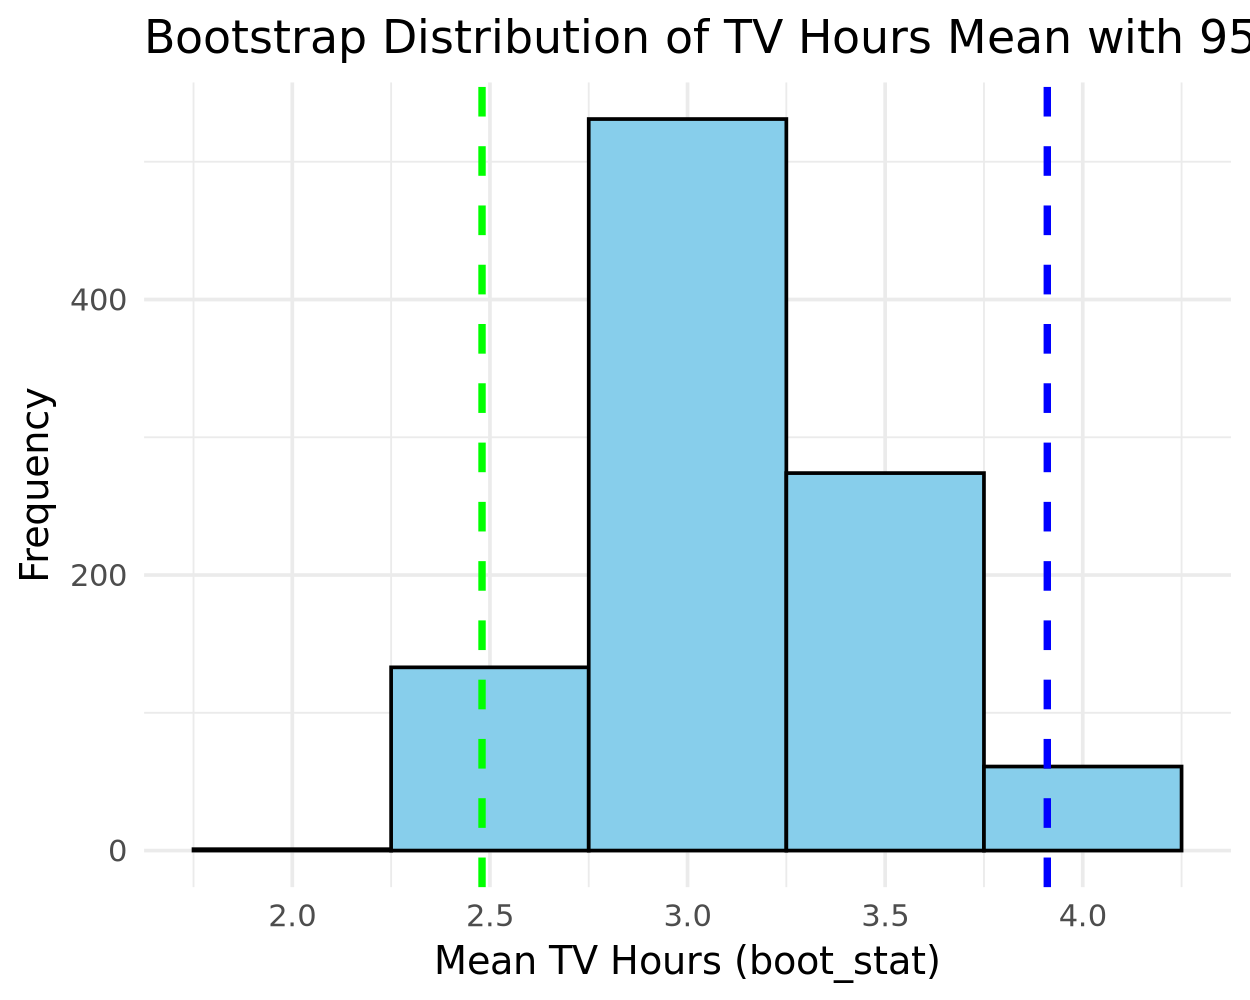

In [20]:
# Plot histogram with CI lines
ggplot(boot_distrib_tv, aes(x = boot_stat)) +
  geom_histogram(binwidth = 0.5, color = "black", fill = "skyblue") +
  geom_vline(xintercept = prct_ci_tv$lower_ci, color = "green", linetype = "dashed", size = 1) +
  geom_vline(xintercept = prct_ci_tv$upper_ci, color = "blue", linetype = "dashed", size = 1) +
  labs(title = "Bootstrap Distribution of TV Hours Mean with 95% CI",
       x = "Mean TV Hours (boot_stat)", y = "Frequency") +
  theme_minimal()


## Question 3

**If** we calculated a **90% confidence interval** for the mean of
`tvhours` using this same bootstrap resample and the percentile method,
roughly how many of the 1000 values of `tv_mean` would fall between the
green and blue lines?

**Answer:** 900 values of tv_mean.

## Question 4

Use the bootstrap resampling distribution for `tvhours` generated above
(`boot_distrib_tv`) and the **percentile** method to calculate a 99%
confidence interval for the mean `tvhours`.

In [22]:
# percentile method
prct_ci = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.005), 
            upper_ci = quantile(boot_stat, 0.995))

# bootstrap method
boot_distrib_tv |>
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (2.576 * se), 
            upper_ci = mean + (2.576 * se))


## Question 5

Which confidence interval is **WIDER**: the 95% confidence interval or
the 99% confidence interval for the population mean `tvhours`
$\mu_{tv}$? Why is this the case? Answer in terms of the trade-off
between confidence level and confidence interval width.

**Answer:** 99% will yield a wider interveal because as confidence levels increase they must capture a larger portion of possible values. 

## Question 6.a)

Use the bootstrap resample we generated above (`boot_samp_1000`), to
generate a **bootstrap distribution** for the sample mean respondent
`age` $\bar{x}$ instead of `tvhours`. Please be sure to **name it
something different** than the bootstrap distribution for the sample
mean of `tvhours`

In [23]:
boot_distrib_age = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat1 = mean(age))

boot_distrib_age |> head()

replicate,boot_stat1
<int>,<dbl>
1,46.31
2,49.52
3,51.08
4,49.66
5,45.78
6,49.86


## Question 6.b)

Calculate a 95% confidence interval for the population mean respondent
`age` $\mu_{age}$ using the **95% rule** method.

In [24]:
# 95% method

boot_distrib_age |>
  summarize(mean = mean(boot_stat1), 
            se = sd(boot_stat1), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))



mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
47.54505,1.761748,44.09202,50.99808


## Question 6.c)

Calculate a 95% confidence interval for the population mean respondent
`age` $\mu_{age}$ using the **percentile** method.

In [26]:
# percentile method

prct_ci_age = boot_distrib_age |> 
  summarize(lower_ci = quantile(boot_stat1, 0.025), 
            upper_ci = quantile(boot_stat1, 0.975))

prct_ci_age

lower_ci,upper_ci
<dbl>,<dbl>
44.12,51.01025


## Question 6.d)

How do the 95% confidence intervals you calculated in 6b and 6c compare?
i.e. are the 95% CI values similar or are they pretty different?

**Answer:** The intervals are similar w/ less than a point difference.

## Question 7

Use the **bootstrap resampling distribution** for the sample mean
respondent `age` and the percentile method to calculate an 80%
confidence interval for the population mean respondent age $\mu_{age}$.

In [27]:
boot_distrib_age = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat1 = mean(age))

boot_distrib_age |> head()



replicate,boot_stat1
<int>,<dbl>
1,46.31
2,49.52
3,51.08
4,49.66
5,45.78
6,49.86


In [29]:
CI_80 = boot_distrib_age |> 
  summarize(lower_ci = quantile(boot_stat1, 0.1), 
            upper_ci = quantile(boot_stat1, 0.9))
CI_80

lower_ci,upper_ci
<dbl>,<dbl>
45.199,49.911


# Bootstrap sampling distribution & confidence intervals with categorical variables

The procedure for generating a bootstrap sampling distribution is VERY
similar for categorical data. As an example we will generate a bootstrap
sampling distribution for the proportion of respondents that identified
as a Person of Color.

### Step 1: Take 1000 bootstrap resamples

We already did this above! We can use the same `boot_samp_1000` as
before.

### Step 2: Calculate the bootstrap statistic $\hat{p}$

In [30]:
boot_distrib_POC = boot_samp_1000 |> 
  group_by(replicate) |> 
  summarize(n = n(), 
            POC_count = sum(race == "POC"), 
            boot_stat = POC_count/n)

boot_distrib_POC |> head()

replicate,n,POC_count,boot_stat
<int>,<int>,<int>,<dbl>
1,100,24,0.24
2,100,18,0.18
3,100,24,0.24
4,100,23,0.23
5,100,14,0.14
6,100,22,0.22


Note that with a categorical variable, the code differs in two important
respects now:

-   the population parameter that we don’t know, but are inferring about
    via sampling, is now the population proportion $p$ that identify as
    a POC.
-   the sample statistic AKA point estimate that we calculate with the
    summarize command is now the **sample proportion** $\widehat{p}$
    rather than a sample mean $\bar{x}$
-   To get our proportion $\widehat{p}$ of **ONE** of the race
    categories (POC), we need to **first** calculate the total sample
    size for each replicate and the count of how many cases are
    `race == "POC"` in each replicate.

### Step 3: Generate the 95% Confidence Interval

### a) CI using the 95% rule

The following will calculate the 95% confidence interval for the
proportion of people that identified as `POC` using the 95% rule.

In [31]:
boot_distrib_POC |> 
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.24074,0.0428963,0.1566633,0.3248167


### b) CI with the percentile method

The following will calculate the 95% confidence interval for the
proportion of people that identified as “POC” using the percentile
method.

In [32]:
boot_distrib_POC |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
0.16,0.33


## Question 8

Calculate a 95% CI for the **population proportion** of respondents $p$
that identified as **White** using EITHER the percentile or 95% rule
method. Note that you will first need to generate the bootstrap
distribution for the proportion of respondents that identified as
`White`.

In [36]:
boot_distrib_W = boot_samp_1000 |> 
  group_by(replicate) |> 
  summarize(n = n(), 
            W_count = sum(race == "White"), 
            boot_stat = W_count/n)

boot_distrib_W |> head()

replicate,n,W_count,boot_stat
<int>,<int>,<int>,<dbl>
1,100,76,0.76
2,100,82,0.82
3,100,76,0.76
4,100,77,0.77
5,100,86,0.86
6,100,78,0.78


In [38]:
boot_distrib_W |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
0.67,0.84


# Confidence intervals based on the theoretical normal distribution

As described in [moderndive chapter
8.7.2](https://moderndive-bert.netlify.com/8-confidence-intervals.html#theory-ci),
not only can we generate confidence intervals using a
computer/resampling as we’ve been doing until now, in many cases there
also exists a mathematical formula! This however necessitates a little
mathematical/probability theory; a topic we leave to a more advanced
statistics class.

To generate a 95% confidence interval based on the theoretical normal
distribution, we can use the following formula:

$$ \text{point estimate} \pm 1.96 \cdot \widehat{SE}$$

So, for instance if we wanted to calculate the 95% confidence interval
for the population mean of `tvhours` $\mu_{tv}$ that respondents watched
based on our sample:

-   the **point estimate** AKA **sample statistic** in this case would
    be the sample mean number of `tvhours` from the sample: $\bar{x}$
-   We would estimate the standard error using the formula

$$\widehat{SE} \approx \frac{s}{\sqrt{n}}$$

where $s$ is the **sample standard deviation**, which is a point
estimate of the **population standard deviation** $\sigma$.

Thus a 95% CI would be

$$
\bar{x} \pm 1.96 \cdot \widehat{SE} =  \bar{x} \pm 1.96 \cdot \frac{s}{\sqrt{n}}
$$

We can make these calculations in R like so:

In [39]:
gss_sample |> 
  summarize(x_bar = mean(tvhours), 
            sd = sd(tvhours), 
            n = n(), 
            se = sd/sqrt(n), 
            lower_ci = x_bar - 1.96 * se, 
            upper_ci = x_bar + 1.96 * se)

x_bar,sd,n,se,lower_ci,upper_ci
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
3.14,3.592979,100,0.3592979,2.435776,3.844224


## Question 9

Write down the three 95% confidence intervals for the population mean of
`tvhours` $\mu_{tv}$ you’ve computed in this problem set. Do this by
replacing X, Y, A, B, P, and Q with the appropriate values you’ve
computed.

When you are done, make sure all the `|` in the table still line up so
your results print out in a table!

| CI construction method          | lower value | upper value |
|---------------------------------|-------------|-------------|
| Using boostrap: 95% rule        | 0.67           | 0.84           |
| Using boostrap: percentile rule | 0.16           | 0.33           |
| Using mathematical formula      | 2.43           | 3.84           |

## Question 10

**In your opinion**, would you say these three confidence intervals are
similar?

**Answer:** The 95% and percentile methods are similar with a 0.17 difference. In regards to the mathematical formula there is a larger (wider) varience between intervals.